In [8]:
import numpy as np                               
import pandas as pd                             
from math import sqrt
from calendar import monthrange

import matplotlib.dates as mdates
import matplotlib.pyplot as plt                  

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Parameters

In [9]:
file_path = '../data/bike_sharing_data/day.csv'

# Building a multivariate LSTM Network

## 0) Load & pre-process the data

In [10]:
df = pd.read_csv(file_path, index_col=['dteday'], parse_dates=['dteday'])
# drop the `instant` col, which is just a row counter
df = df.drop('instant', 1)

In [11]:
# move `cnt`, our target to the first variable
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [12]:
# # Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name

In [13]:
# drop covariates that we won't need 
df = df.drop(['season', 'yr', 'mnth', 'weekday', 'atemp', 'casual', 'registered'], 1)

In [14]:
print("Dimensions of the data: ", df.shape)
df.head()

Dimensions of the data:  (731, 10)


,cnt,holiday,workingday,weathersit,temp,hum,windspeed,Year,Month,Weekday Name
dteday,,,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.805833,0.160446,2011,1,Saturday
2011-01-02,801,0,0,2,0.363478,0.696087,0.248539,2011,1,Sunday
2011-01-03,1349,0,1,1,0.196364,0.437273,0.248309,2011,1,Monday
2011-01-04,1562,0,1,1,0.200000,0.590435,0.160296,2011,1,Tuesday
2011-01-05,1600,0,1,1,0.226957,0.436957,0.186900,2011,1,Wednesday


## 1) Visualize trends in continuous data
#### Plot Total Rental Bikes by Day

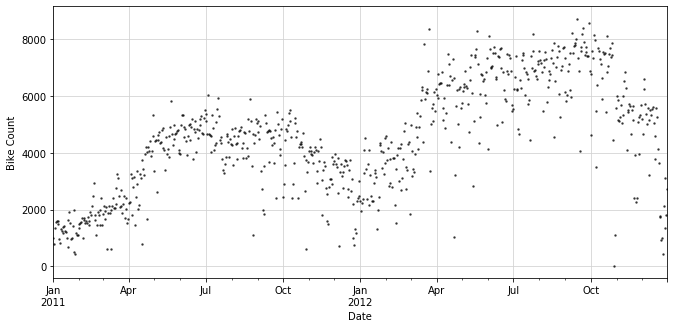

In [42]:
# visualization of just total bike rentals
df['cnt'].plot(marker='o', markersize=1.5, alpha=0.6, linestyle='None', color='black', figsize=(11, 5))


plt.rc('axes', axisbelow=True)
plt.grid(color='lightgray', linestyle='-')

#plt.title("Total Rental Bikes by Day")
plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.show()

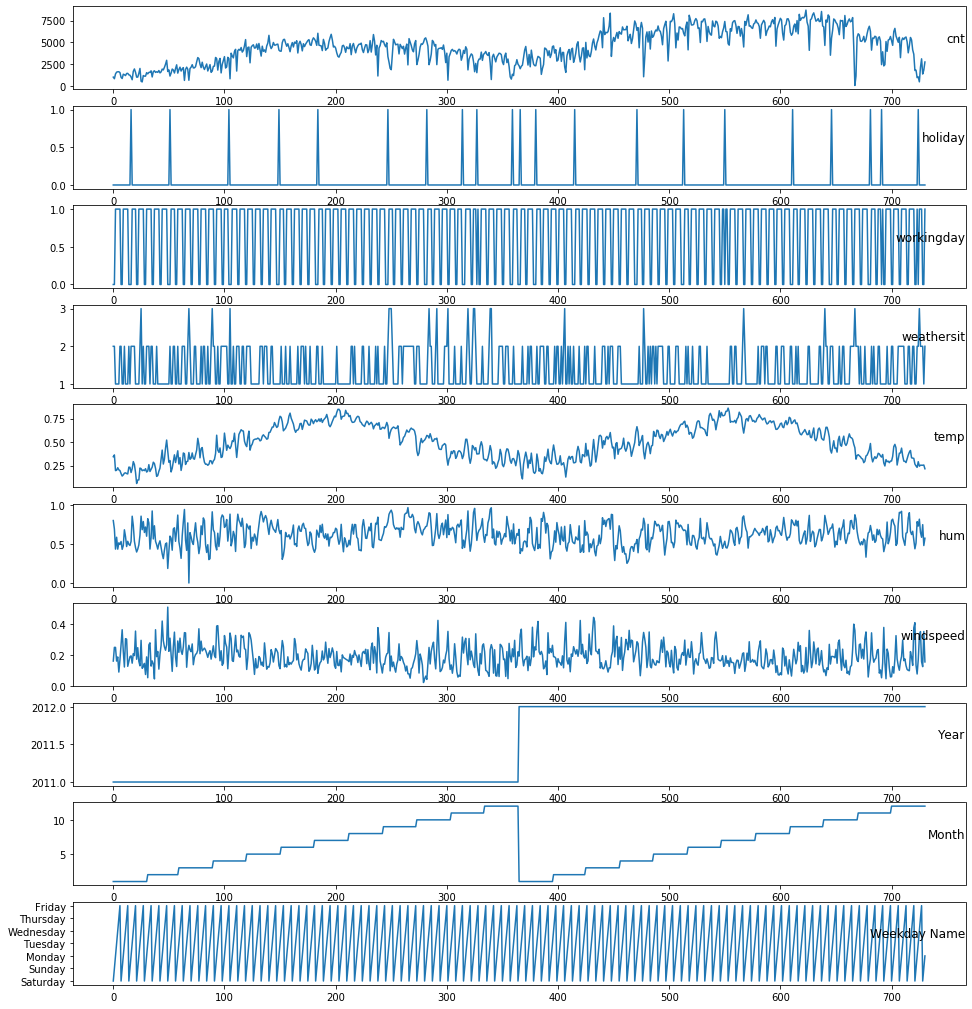

In [43]:
values = df.values

# specify columns to plot
groups = list(range(0, 10))
i = 1

# plot each column
plt.figure(figsize=(16, 18))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## 2) Basic case: 1 train & test split
Predict the bike rental counts in the last 30 days after training on all days prior to the last 30 days.

In [44]:
### PARAMETERS
n_train_hours = 365 # specifying that we want to train on 2011 data

#### Helper functions

In [45]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Data transformations before modeling

In [46]:
values = df.values

# integer encode categorical data
encoder = LabelEncoder()
for i in range(7, 10):
    values[:,i] = encoder.fit_transform(values[:,i])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
drop_cols = list(range(11, 20))
reframed.drop(reframed.columns[drop_cols], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.110792        0.0        0.0        0.5   0.355170   0.828620   
2   0.089623        0.0        0.0        0.5   0.379232   0.715771   
3   0.152669        0.0        1.0        0.0   0.171000   0.449638   
4   0.177174        0.0        1.0        0.0   0.175530   0.607131   
5   0.181546        0.0        1.0        0.0   0.209120   0.449313   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1   0.284606        0.0        0.0    0.333333  0.089623  
2   0.466215        0.0        0.0    0.500000  0.152669  
3   0.465740        0.0        0.0    0.166667  0.177174  
4   0.284297        0.0        0.0    0.833333  0.181546  
5   0.339143        0.0        0.0    1.000000  0.182237  


In [47]:
# split into train and test sets
values = reframed.values

train = values[:n_train_hours, :]
test = values[n_train_hours: n_train_hours+30, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#### Fit the model

We define a LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting bike rental counts. The input shape will be 1 time step with 10 features.

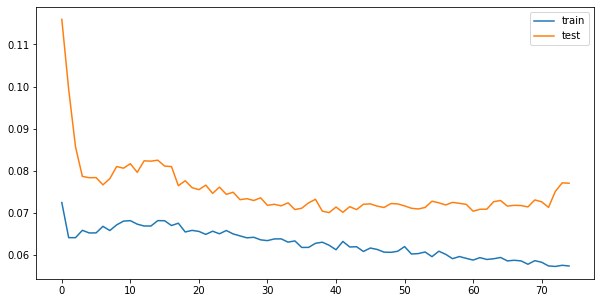

In [48]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=75, batch_size=1, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Use the model to compute training error

In [15]:
# make a prediction
yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, train_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 819.564


#### Predict bike rental counts for each day in the test set one at a time & compute test error

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 890.925


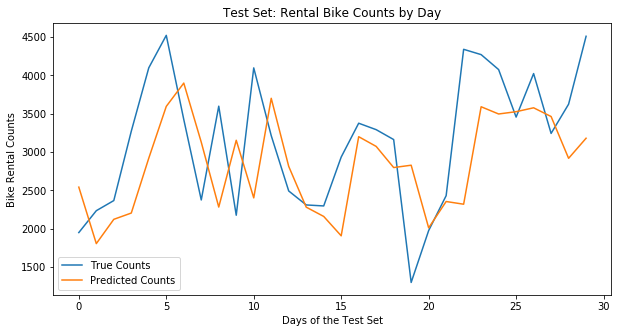

In [53]:
# line plot of observed vs predicted
plt.figure(figsize=(10, 5))
plt.plot(inv_y, label="True Counts")
plt.plot(inv_yhat, label="Predicted Counts")

plt.title("Test Set: Rental Bike Counts by Day")
plt.xlabel('Days of the Test Set')
plt.ylabel('Bike Rental Counts')
plt.legend()
plt.show()

In [52]:
# rename the array with predictions for Dec 2012
dec_preds = inv_yhat

In [128]:
# # pad with `None` values for non-test days
# dec_preds_pad = [None] * (len(df['cnt']) - len(dec_preds)) 
# dec_preds_pad = np.concatenate((dec_preds_pad, dec_preds), axis=None)
# # append the list of predictions to our original data frame
# df['test_pred'] = dec_preds_pad

## 3) Using walk-forward validation to backtest our model

To get a sense of RMSE/MSE at multiple points in time (i.e., backtesting model performance). 

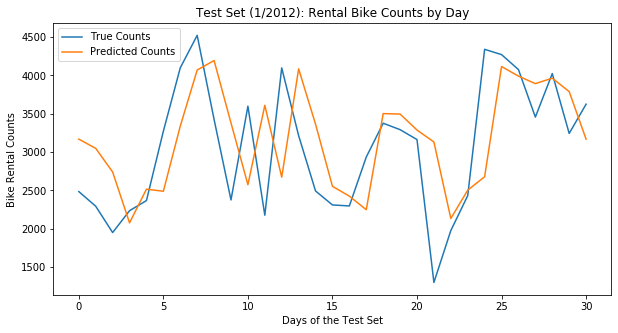

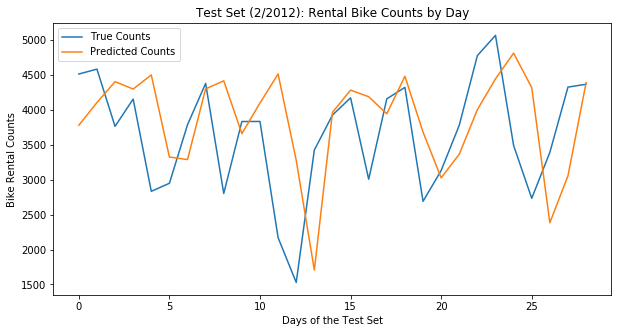

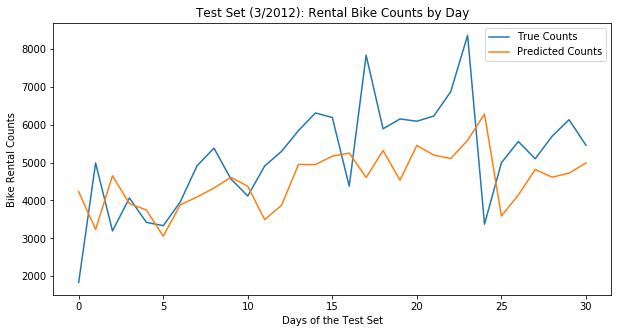

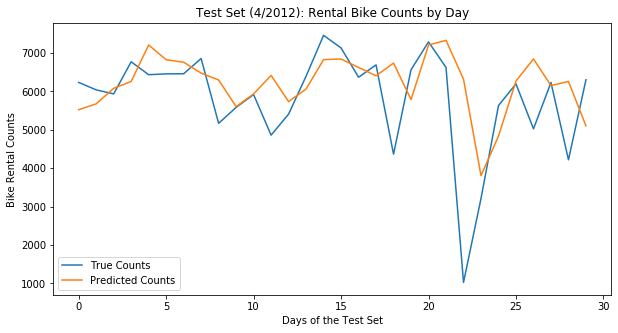

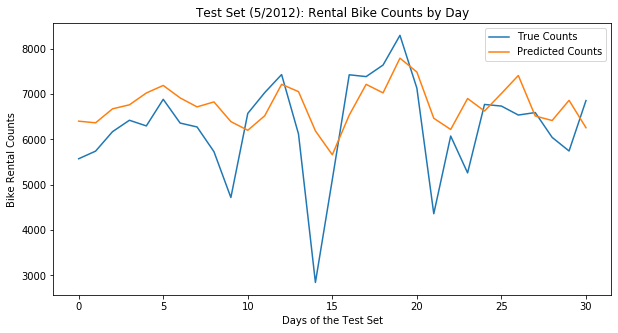

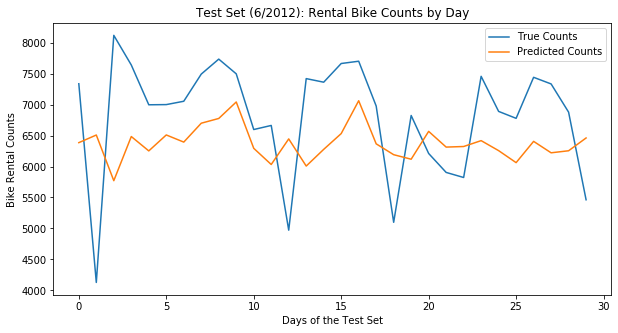

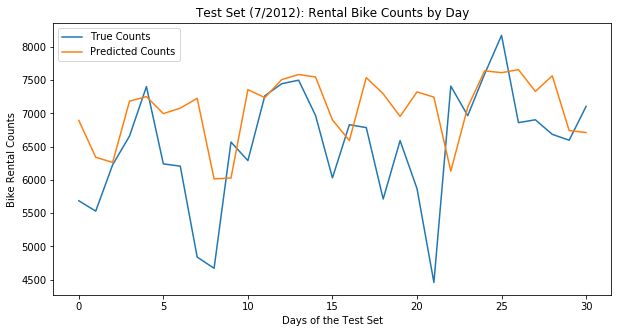

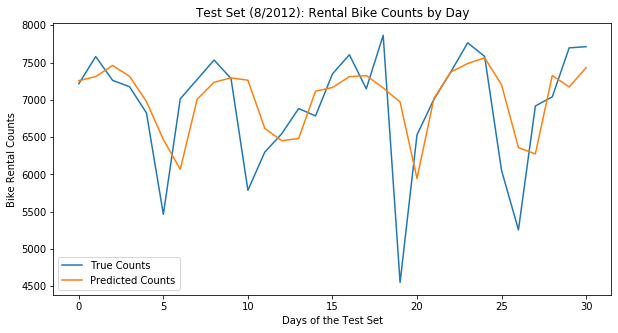

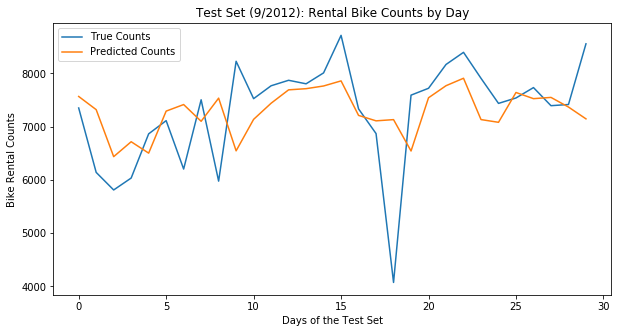

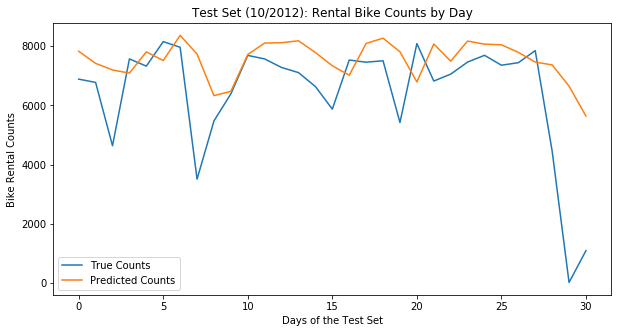

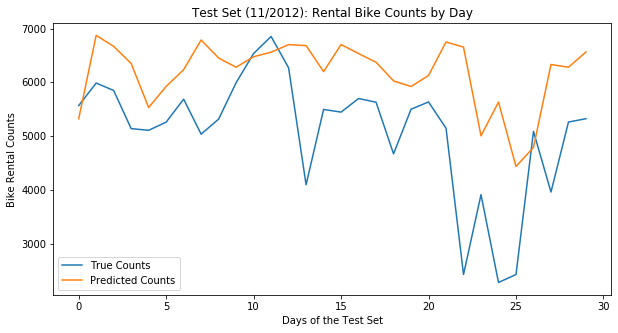

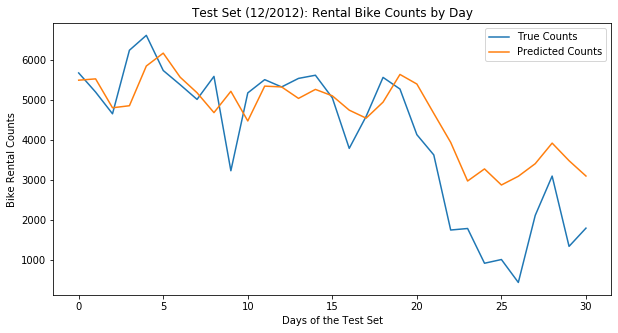

In [65]:
# how many days to use in the training set initially
days = 364 

# to store the model's predictions
predicted_list = [] 

# to store the model's performance
test_rmse_list = []
train_rmse_list = []

# iterate through the 12 months of 2012
for i in range(1, 13):
    # get the # of days in the month of interest
    test_days = monthrange(2012, i)[1]
    # add it to the days used for training
    days += test_days 
    # isolate just the train and test data
    values = df[:days].values

    # integer encode categorical data
    encoder = LabelEncoder()
    for j in range(7, 10):
        values[:,j] = encoder.fit_transform(values[:,j])
    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    drop_cols = list(range(11, 20))
    reframed.drop(reframed.columns[drop_cols], axis=1, inplace=True)
    
    # split into train and test sets
    values = reframed.values

    train = values[:-test_days, :]
    test = values[-test_days: , :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, epochs=75, batch_size=1, validation_data=(test_X, test_y), verbose=0, shuffle=False)

#     # plot history
#     plt.figure(figsize=(10, 5))
#     plt.plot(history.history['loss'], label='train')
#     plt.plot(history.history['val_loss'], label='test')
#     plt.legend()
#     plt.show()
    
    ### obtain train RMSE
    # make a prediction
    yhat = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, train_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y = np.concatenate((train_y, train_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #print('Train RMSE: %.3f' % train_rmse)
    train_rmse_list.append(rmse)
    
    # store predictions for the training data only during the first loop
        # (needed for our plot)
    if i == 1:
        # store predictions
        predicted_list.append(inv_yhat)
    
    ### obtain test RMSE
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # store predictions
    predicted_list.append(inv_yhat)
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #print('Test RMSE: %.3f' % rmse)
    test_rmse_list.append(rmse)
    
    # line plot of observed vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(inv_y, label="True Counts")
    plt.plot(inv_yhat, label="Predicted Counts")

    plt.title("Test Set ({i}/2012): Rental Bike Counts by Day".format(i=i))
    plt.xlabel('Days of the Test Set')
    plt.ylabel('Bike Rental Counts')
    plt.legend()
    plt.show()

## 4) Create plot with LSTM forecast for the writeup

In [68]:
# flatten list
predicted_list = [item for sublist in predicted_list for item in sublist]
predicted_list.append(0)
predicted_list.insert(0, 0)
predicted_list[0] = None
predicted_list[730] = None

# append the list of predictions to our original data frame
df['preds'] = predicted_list

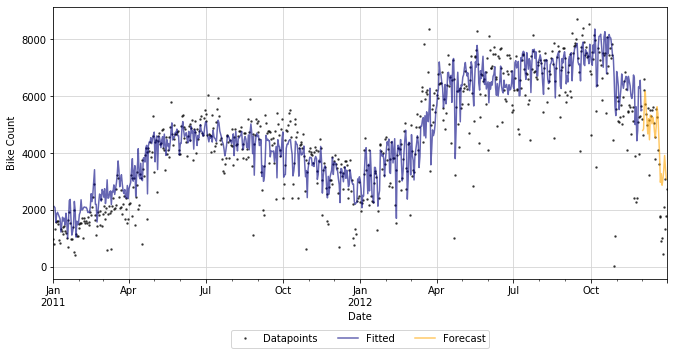

In [163]:
# plot both forecasting and fitting on original data after cross validation
df['cnt'].plot(marker='o', markersize=1.5, alpha=0.6, linestyle='None', color='black', figsize=(11, 5), \
               label='Datapoints')
df['preds'][0:701].plot(alpha=0.6, linestyle='-', color='navy', figsize=(11, 5), label = 'Fitted')
df['preds'][701:731].plot(alpha=0.6, linestyle='-', color='orange', figsize=(11, 5), label = 'Forecast')


plt.rc('axes', axisbelow=True)
plt.grid(color='lightgray', linestyle='-')

# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
          fancybox=True, shadow=False, ncol=5)

plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.savefig('lstm_forecast.png')